# Random Forest Regressor

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import randint
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from faa_p2.config import (
    CLEAN_DATA_FILE,
    DATA_SPLIT_RATIO,
    MODEL_RESULTS_FILE,
    MODELS,
    RANDOM_STATE,
    RFR,
)

warnings.filterwarnings("ignore")


Load the data.

In [2]:
df = pd.read_csv(CLEAN_DATA_FILE, index_col=0)
df.head()

,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
crim,,,,,,,,,,,,,
0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
y = df["medv"]
x = df.drop(columns=["medv"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=DATA_SPLIT_RATIO, random_state=RANDOM_STATE
)

Model configurations

In [4]:
key = RFR
config = MODELS[key]

## Default model

In [5]:
default_model = config["class"]()
default_model.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [6]:
default_y_pred = default_model.predict(x_test)
default_y_pred_train = default_model.predict(x_train)

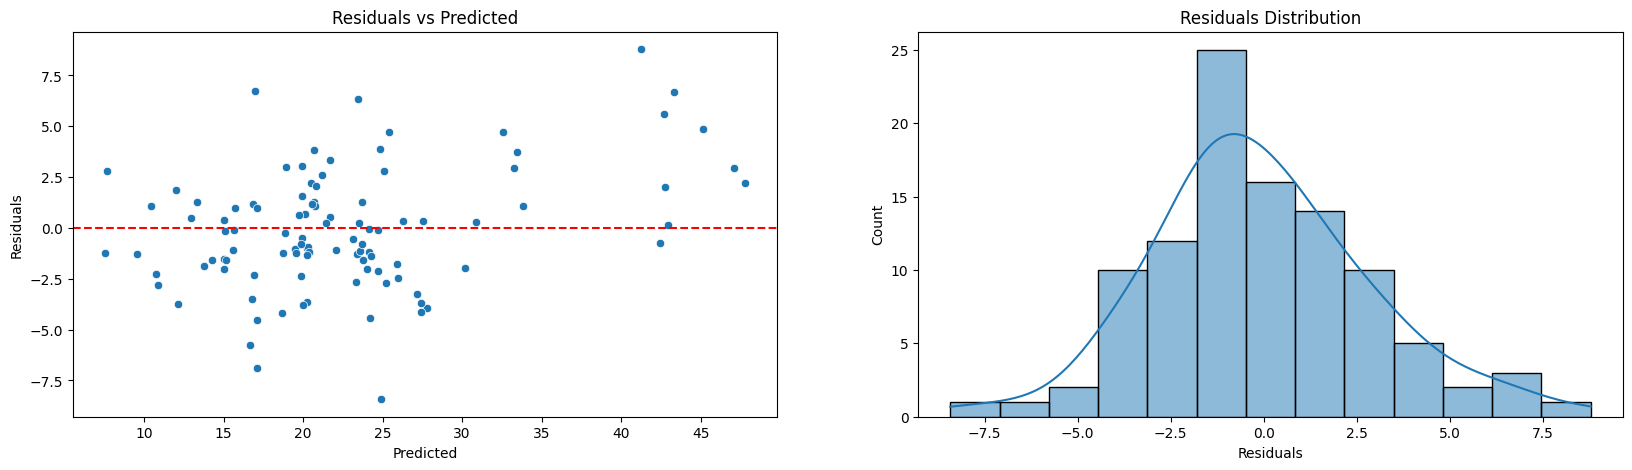

In [7]:
residuals = y_test - default_y_pred

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Residuals vs Fitted
sns.scatterplot(x=default_y_pred, y=residuals, ax=ax1)
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Residuals")
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title("Residuals vs Predicted")

# Histogram
sns.histplot(residuals, kde=True, ax=ax2)
ax2.set_xlabel("Residuals")
ax2.set_title("Residuals Distribution")
plt.show()

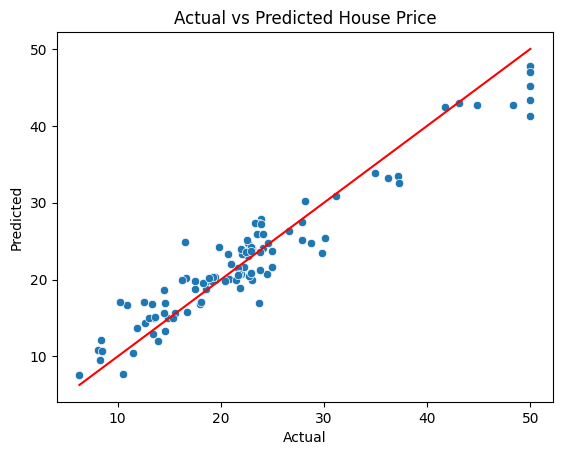

In [8]:
sns.scatterplot(x=y_test, y=default_y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted House Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')   
plt.show()

In [9]:
res = {}

mae_train = mean_absolute_error(y_train, default_y_pred_train)
rmse_train = root_mean_squared_error(y_train, default_y_pred_train)
r2_train = r2_score(y_train, default_y_pred_train)

# test metrics
mae = mean_absolute_error(y_test, default_y_pred)
rmse = root_mean_squared_error(y_test, default_y_pred)
r2 = r2_score(y_test, default_y_pred)

residuals = y_test - default_y_pred

res["default"] = {
    "model": config["name"],
    
    "train_mae": mae_train,
    "train_rmse": rmse_train,
    "train_r2": r2_train,
    
    "test_mae": mae,
    "test_rmse": rmse,
    "test_r2": r2,
    "rmse_gap": rmse - rmse_train,
}
res


{'default': {'model': 'Random Forest Regressor',
  'train_mae': 0.8204430693069299,
  'train_rmse': 1.2049362160104014,
  'train_r2': 0.9820271553129137,
  'test_mae': 2.274411764705881,
  'test_rmse': 2.9346631165847863,
  'test_r2': 0.9128556602130854,
  'rmse_gap': 1.729726900574385}}

## CV model

In [10]:
# Hyperparameter grid
param_dist = {
    "n_estimators": randint(50, 200),
    "max_features": ["auto", "sqrt"],
    "max_depth": randint(1, 20),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 10),
}

random_search = RandomizedSearchCV(
    estimator=config["class"](),
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring="r2",
    random_state=RANDOM_STATE,
)
random_search.fit(x_train, y_train)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestRegressor()
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': <scipy.stats....0024180C01110>, 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': <scipy.stats....0024184E1C950>, 'min_samples_split': <scipy.stats....0024184DF0C50>, ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",100
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variousc

In [11]:
print("The best parameters:", random_search.best_params_)
print("The best score:", random_search.best_score_)
best_model = random_search.best_estimator_

The best parameters: {'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 195}
The best score: 0.8469336326991186


In [12]:
y_pred = best_model.predict(x_test)
y_pred_train = best_model.predict(x_train)

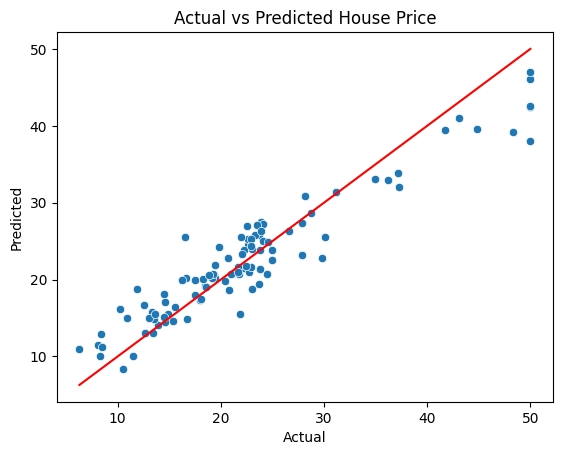

In [13]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted House Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')   
plt.show()

In [14]:
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# test metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

residuals = y_test - y_pred

res["cv"] = {
    "model": config["name"],
    
    "train_mae": mae_train,
    "train_rmse": rmse_train,
    "train_r2": r2_train,
    
    "test_mae": mae,
    "test_rmse": rmse,
    "test_r2": r2,
    "rmse_gap": rmse - rmse_train,
}

In [15]:
pd.DataFrame(res)

,default,cv
model,Random Forest Regressor,Random Forest Regressor
train_mae,0.820443,1.01038
train_rmse,1.204936,1.531874
train_r2,0.982027,0.970951
test_mae,2.274412,2.554358
test_rmse,2.934663,3.378962
test_r2,0.912856,0.884471
rmse_gap,1.729727,1.847088


## Comparison of default and cv model

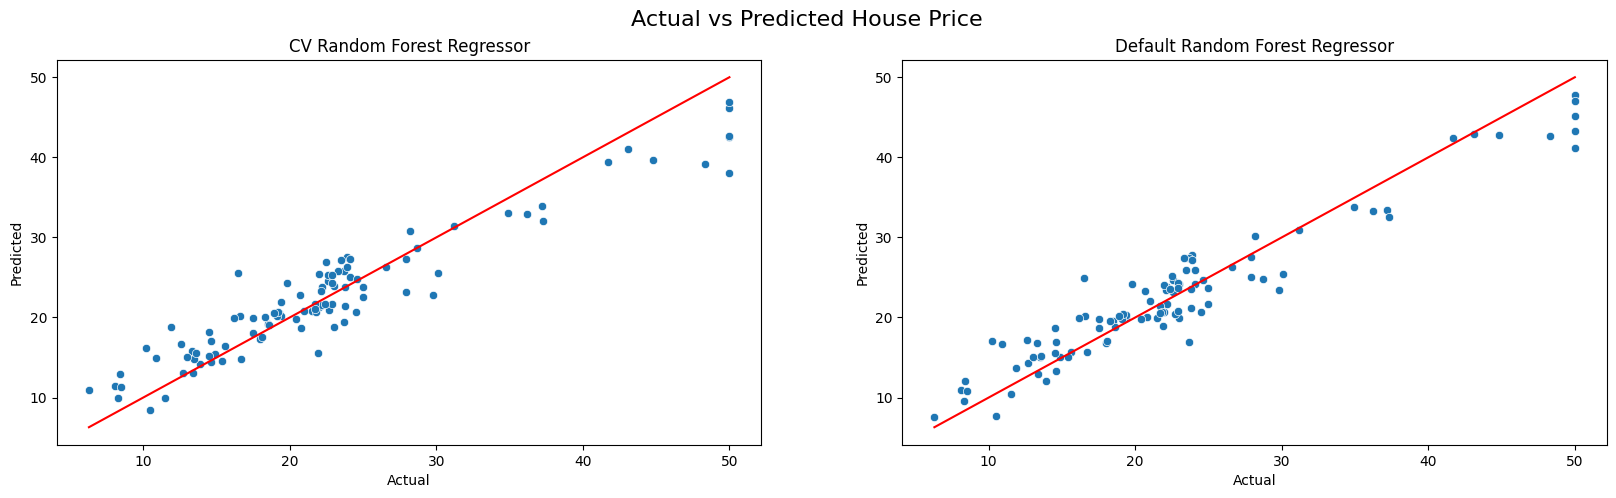

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.scatterplot(x=y_test, y=y_pred, ax=ax1)
ax1.set_xlabel("Actual")
ax1.set_ylabel("Predicted")
ax1.set_title(f"CV {config['name']}")

ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')   

sns.scatterplot(x=y_test, y=default_y_pred, ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_ylabel("Predicted")
ax2.set_title(f"Default {config['name']}")
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')   

fig.suptitle("Actual vs Predicted House Price", fontsize=16)
plt.show()

In [17]:
results = pd.read_csv(MODEL_RESULTS_FILE)

results = results.set_index("model")
model_name = config["name"]
model_file = config["filename"]
new_metrics = res["cv"]
new_r2 = new_metrics["test_r2"]

is_new = model_name not in results.index
is_file = model_file.exists()
is_better = not is_new and (new_r2 > results.at[model_name, "test_r2"])

if not is_file or is_new or is_better:
    results.loc[model_name] = new_metrics
    results.reset_index().to_csv(MODEL_RESULTS_FILE, index=False)
    # update or save the model
    joblib.dump(best_model, model_file)
    print(f"Updated {model_name} with R2: {new_r2}")
else:
    print(f"Existing {model_name} performance is better. Skipping update.")

Updated Random Forest Regressor with R2: 0.8844714466683897
